# Сегментация изображений

## Сегментация изображений с помощью порогов

1. Построить гистограммы по трем (RGB) составляющим изображения. По оси абсцисс откладывается значение составляющей, а по оси ординат количество пикселов, имеющих соответствующее значение составляющей. При необходимости провести сглаживание гистограммы:
$$
\hat{g}_i=\frac{1}{n} \sum_{j=-\frac{n}{2}}^{\frac{n}{2}}g_{i+j}
$$
где $\hat{g}_i$ - новое значение столбца гистограммы, $n$ - ширина фильтра сглаживания.

2. По гистограмме определить значение порогов сегментации:
значения порогов по каждой составляющей определяются по локальным минимумам гистограмм;
значения составляющих изображения, лежащие в пределах между двумя минимумами гистограммы можно отнести к одной области (сегменту) изображения.

3. Однородные области изображения окрасить в псевдоцвета.

### Пример

Загрузка изображения

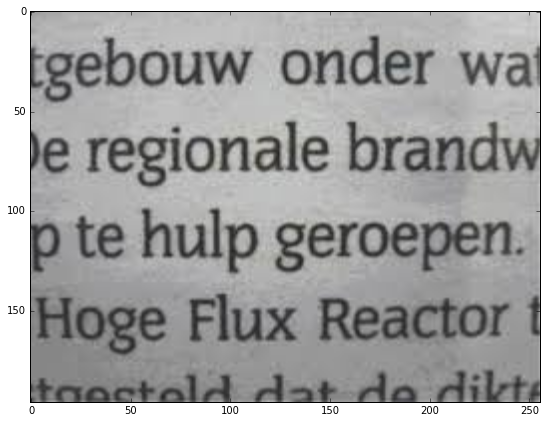

In [78]:
import matplotlib.image as imr
im = imr.imread('files2/test_image1.jpg')
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,7)
plt.imshow(im)
plt.show()

Построение гистограмм

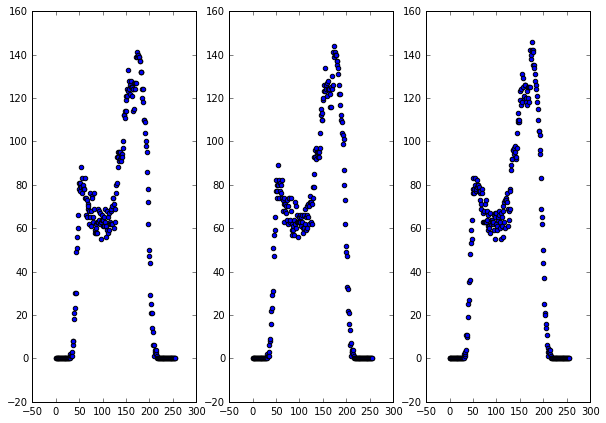

In [79]:
import numpy as np

def histogram(im, bins):
    res = np.zeros(bins)
    for i in im: res[i] = res[i] + 1
    return res

h1 = histogram(im[:,:,0], 256)
h2 = histogram(im[:,:,1], 256)
h3 = histogram(im[:,:,2], 256)
plt.subplot(131)
plt.scatter(np.arange(256), h1)
plt.subplot(132)
plt.scatter(np.arange(256), h2)
plt.subplot(133)
plt.scatter(np.arange(256), h3)

Сглаживание и нахождение локальных минимумов

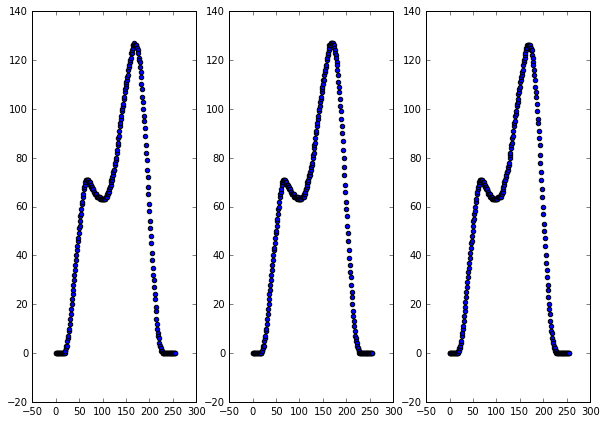

In [80]:
def smooth (g, n):
    res=np.zeros_like(g)
    for i in range(g.shape[0]):
        s=0
        for j in range(-n//2, n//2):
            inx = i+j
            if inx >= 0 and inx<g.shape[0]:
                s=s+g[inx]
        res[i]=s//n
    return res

n=40 # Ширина окна сглаживания
_h1 = smooth(h1,n)
_h2 = smooth(h2,n)
_h3 = smooth(h3,n)
plt.subplot(131)
plt.scatter(np.arange(256),_h1)

plt.subplot(132)
plt.scatter(np.arange(256),_h2)
plt.subplot(133)
plt.scatter(np.arange(256),_h3)

def locmin(g):
    res=[]
    for i in range(1, g.shape[0]-1):
        if g[i-1]>g[i] and g[i]<g[i+1]:
             res.append(i)
    res.append(255)
    return res
# Поиск локальных минимумов
l1 = locmin(_h1)
l2 = locmin(_h2)
l3 = locmin(_h3)

Раскрашивание изображение в псевдоцвета

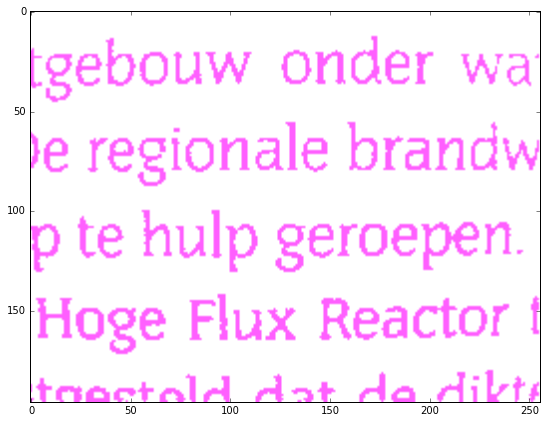

In [81]:
def colored(h, lm):
    for i in range(h.shape[0]):
        for j in range(h.shape[1]):
            for lc in lm:
                if h[i,j]<lc:
                    h[i,j]=lc
                    break
    return h
im[:,:,0]=colored(im[:,:,0],l1)
im[:,:,1]=colored(im[:,:,1],l2)
im[:,:,2]=colored(im[:,:,2],l3)
plt.imshow(im)
plt.show()

# Динамическая сегментация изображений

Суть метода сегментации изображения с динамически изменяющимся порогом заключается в следующем:
1. В первую очередь необходимо определить приемлемый диапазон изменений $P$ цвето-яркостных характеристик элементов изображения (пикселов), который будет служить критерием принадлежности пикселов одному сегменту. 
2. Разбиение на сегменты начинается с того, что фиксируется определенный пиксел, который рассматривается как элемент сегмента. 
3. Затем рассматриваются элементы, граничащие с сегментом (на первом проходе сегмент состоит из единственного фиксированного пиксела).
4. Вычисляется так называемая "базовая яркость" или "базовый цвет" по формуле:
$$
I_{i}^{b}=\frac{1}{i}\sum_{j=1}^{i}I_{j},
$$
где $I_{j}$ - яркость (цветовая характеристика) пиксела $j$.
 На первом шаге - это значение яркости (цветовой характеристики) первого  пиксела.
5. Вычисляется критерий принадлежности очередного граничного элемента к сегменту:
$$
\begin{equation}
|I_{i}^{b} - I_{i}| \leq P \tag{1}
\end{equation}
$$
Если неравенство выполняется, то рассматриваемый элемент изображения  приписывается сегменту.
6. Пункты 3-5 выполняются до тех пор, пока существуют граничащие с сегментом элементы изображения, удовлетворяющие критерию (1). Формирование сегмента завершается, если не окажется ни одного такого элемента.
7. Затем начинается формирование нового сегмента с фиксации пиксела, не принадлежащего ни одному из вновь образованных сегментов. Предыдущие шаги выполняются до тех пор, пока не будут рассмотрены все пикселы изображения.
8. Для цветного изображения может быть применен следующий критерий объединения пикселов в сегменты: 
$$
\sqrt{(R_C - R)^{2}+(G_C - G)^{2}+(B_C - B)^{2}} \leq P
$$
где  $R_c G_c B_c$ – базовый цвет сегмента и $RGB$ - цвет тестируемого пиксела.

Всего сегментов: 145


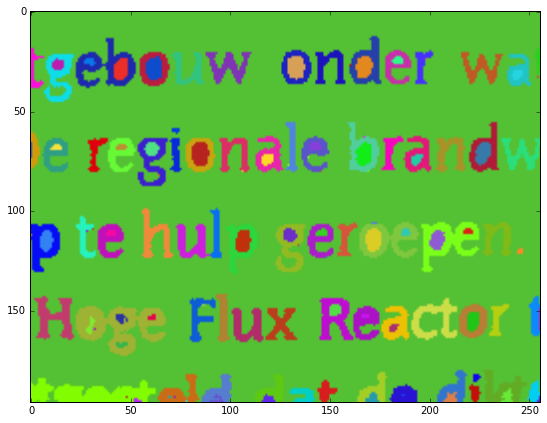

In [82]:
# Функция, возвращающая случайный цвет
def random_color():
    h,s,l = random.random(), 0.5 + random.random()/2.0, 0.4 + random.random()/5.0
    r,g,b = [int(256*i) for i in colorsys.hls_to_rgb(h,l,s)]
    return [r, g, b]

# Метрика (пункт 8)
def metric(x1, x2):
    return np.sqrt(np.sum((x1-x2)**2)) 

# Рекурсивная функция добавления пикселя в сегмент
# Pc - приемлемый диапазон, x - координаты добавляемого писеля,
# seg - матрица сегментов, im - изображение,
# P - сумма яркостей пикселей в сегменте,
# n - количество пикселей в сегменте, n - номер сегмента
def append(Pc, x, seg, im, P, n, i):
    # Добаляемый пиксель помечается принадлежащим текущему сегменту 
    seg[x[0],x[1]]=i
    n=n+1 # Увеличивается количество пикселей в сегменте
    P=P+im[x[0],x[1],:] #Яркость добавленого пикселя добавляется к сумме яркостей
    for w in range(-1,2): # Циклы, проходящие
        for h in range(-1,2): # восемь соседей добавленного пикселя
            if w==0 and h==0: continue # но сам пиксел не является своим соседом
            cx=x[0]+w; cy=x[1]+h # Координаты n-го соседа
            # и если они выходят за пределы изображения,
            # то переходим к следующему соседу
            if cx<0 or cy<0 or cx>=im.shape[0] or cy>= im.shape[1]: continue
            #Если n-й сосед уже входит в какой-либо сегмент,
            if seg[cx, cy] !=0: continue # то он пропускается
            # Находим расстояние между базовой яркостью сегмента
            Pi=metric(P/n, im[cx, cy, :]) # и яркостью n-го соседа
            if Pi<=Pc: # и если оно меньше или равно приемлемому
                try:
                    # добавляем n-ный сосед в текущий сегмент
                    seg, P, n = append(Pc, [cx, cy], seg, im, P, n, i)
                except Exception:
                    print("Достигнут лимит вызова рекурсий!")
    # возвращается матрица сегментов, сумма яркостей пикселей в сегменте
    return(seg, P, n) # и количество пикселей в сегменте

# Функция динамической сегментации
# im - изображение, Pc - приемлемый диапазон (пункт 1)
def din_seg(im, Pc):
    # создается матрица сегментов
    seg = np.zeros([im.shape[0], im.shape[1]])
    si=1 # счетчик сегментов
    while True:
        #Ищется первый пиксель, не принадлежащий
        x=np.where(seg==0) # какому-либо сегменту
        # Если такого нет
        if len(x[0])==0 or len(x[1]) == 0: break # то выходим из цикла
        # Если есть, то добавляем его в текущий сегмент
        seg, _, _ = append(Pc,[x[0][0],x[1][0]], seg, im,[0.,0.,0.], 0, si)
        cl = random_color() # Случайный цвет
        for i in range (im.shape[0]): # которым мы раскрашиваем
            for j in range (im.shape[1]): # каждый пиксель изображения
                # который принадлежит
                if seg[i,j]==si: im[i,j]=cl # текущему сегменту
        si=si+1
    # возвращаем количество сегментов
    return si

import resource, sys
import random
import colorsys
im = imr.imread('files2/test_image1.jpg')
# Запрашивается большой стек
resource.setrlimit(resource.RLIMIT_STACK, (2**29,-1))
# и большой лимит вызова рекурсий
sys.setrecursionlimit(10**6)
# Динамическая сегментация 
P = 90. # с приемлемым диапазоном равным
seg_count = din_seg(im, P)
print ("Всего сегментов: "+str(seg_count))
plt.imshow(im)
plt.show()

# *Задания для самостоятельной работы:*

1. Реализуйте динамическую сегментацию без использования рекурсии, только с помощью циклов.
2. Реализуйте алгоритм, объединяющий смежные сегменты в один сегмент.
3. Реализуйте алгоритм, берущий в прямоугольную рамочку каждый сегмент.